In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import xarray as xr
import cmocean
import matplotlib as mpl


In [2]:
TS=10
if TS==5:
    WW3 = sio.loadmat( '/archive/Qian.Xiao/Qian.Xiao/ALL_5.mat')
    CaseList = [[46-1,'TC021'],
                [48-1,'TC022'],
                [50-1,'TC023'],
                [51-1,'TC024'],
                [53-1,'TC025'],
                [55-1,'TC026'],
                [57-1,'TC027'],
                [59-1,'TC028'],
                [71-1,'TC030'],
               ]
elif TS==10:
    WW3 = sio.loadmat( '/archive/Qian.Xiao/Qian.Xiao/ALL_10.mat')
    CaseList = [[46-1,'TC052'],
                [48-1,'TC053'],
                [50-1,'TC054'],
                [51-1,'TC055'],
                [53-1,'TC056'],
                [55-1,'TC057'],
                [57-1,'TC058'],
                [59-1,'TC059'],
                [71-1,'TC061'],
               ]

PermissionError: [Errno 13] Permission denied: '/archive/Qian.Xiao/Qian.Xiao/SCM_Forcing/Hurr10_046.nc'

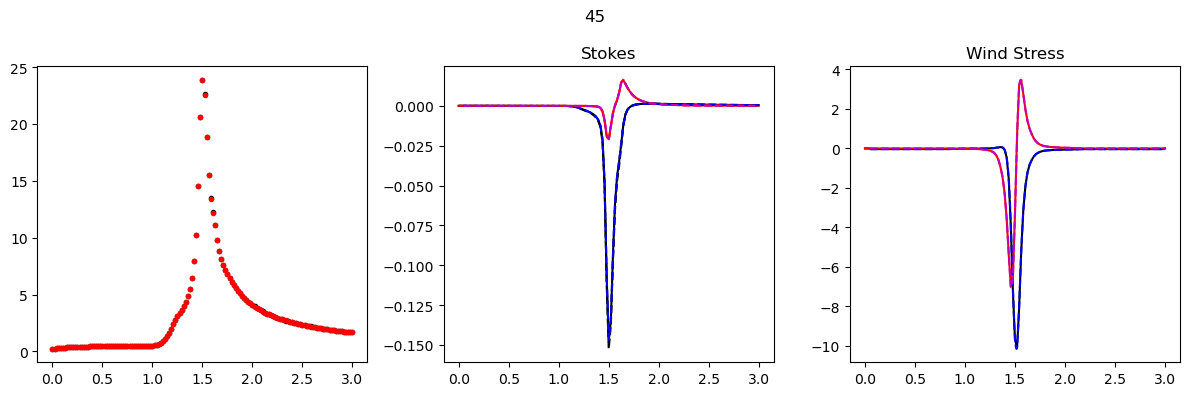

In [3]:

LES_dirs = '/archive/bgr/Datasets/LES/Hurr/LES_HUR/'
stkfac = 2.*np.sqrt(9.81)



for LOC,LES_fname in CaseList:

    
    LES = sio.loadmat( LES_dirs+LES_fname+'_PROF.mat')
    LES_time=LES['t'][:].squeeze()/86400
    LES_UsX=LES['Us'][:].squeeze()
    LES_UsY=LES['Vs'][:].squeeze()
    zl=LES['z'].T[:].squeeze()
    
    
    DPT = 25
    
    element = WW3['WW3'][0][LOC]
    wavenumber = np.squeeze(element['WN'])
    waveheight = np.squeeze(element['HS'])
    wavedirection = np.squeeze(element['WVDIR'])
    spectrum = np.squeeze(element['SPC'])
    YYMMDD = element[0][0]
    HHMMSS = element[0][1]
    datestring = []
    datetime = []
    for ii in range(len(YYMMDD)):
        datestring+=['{:08d} {:06d}'.format(YYMMDD[ii],HHMMSS[ii])]
        datestring[ii] = datestring[ii][0:4]+'-'+datestring[ii][4:6]+'-'+datestring[ii][6:8]+' '+datestring[ii][9:11]+':'+datestring[ii][11:13]+':'+datestring[ii][13:15]
        datetime+=[np.datetime64(datestring[ii]).astype('datetime64[ns]'),]
    Hs = np.zeros(len(YYMMDD))
    Bands = np.array([6.e-3,1.e-02,2.e-02,4.e-02,6.e-02,8e-02,1.e-01,2.e-01,4.e-01,6.e-01,8.e-01,1.,2.,4.])
    StkX0 = np.zeros([len(YYMMDD),len(Bands)])
    StkY0 = np.zeros([len(YYMMDD),len(Bands)])
    
    LEStaux = LES['tau13l'][:][:,0]*1000
    LEStauy = LES['tau23l'][:][:,0]*1000
    wavetaux=np.squeeze(element['WNDx'][:])#Very wrong (empty) so replacing below
    wavetauy=np.squeeze(element['WNDy'][:])
    Time= np.linspace(0,3,145)
    for wnd,WND in enumerate(wavetaux):
        time = Time[wnd]
        wavetaux[wnd]=np.interp(time,LES_time,LEStaux,left=0,right=0)
        wavetauy[wnd]=np.interp(time,LES_time,LEStauy,left=0,right=0)
    StkX = np.zeros(len(YYMMDD))
    StkY = np.zeros(len(YYMMDD))
    for ti in range(len(YYMMDD)):
        for ki in range(len(wavenumber)):
            dkdth = 0.5*(wavenumber[ki]*1.05**2-wavenumber[ki]/1.05**2)*(np.pi/24)
            Hs[ti]+=dkdth*np.sum(spectrum[ki,:,ti])
            StkX[ti]+=dkdth*np.sum(spectrum[ki,:,ti]*np.cos(wavedirection))*wavenumber[ki]**1.5*stkfac*(np.exp(-2*wavenumber[ki]*zl[DPT]))
            StkY[ti]+=dkdth*np.sum(spectrum[ki,:,ti]*np.sin(wavedirection))*wavenumber[ki]**1.5*stkfac*(np.exp(-2*wavenumber[ki]*zl[DPT]))
            b = np.argmin((Bands-wavenumber[ki])**2)
            StkX0[ti,b]+=dkdth*np.sum(spectrum[ki,:,ti]*np.cos(wavedirection))*wavenumber[ki]**1.5*stkfac
            StkY0[ti,b]+=dkdth*np.sum(spectrum[ki,:,ti]*np.sin(wavedirection))*wavenumber[ki]**1.5*stkfac
            
            
        Hs[ti]=4*np.sqrt(Hs[ti])
        for b in range(len(Bands)):
            if (abs(StkX0[ti,b])<1.e-10): StkX0[ti,b]=0.0
            if (abs(StkY0[ti,b])<1.e-10): StkY0[ti,b]=0.0
    f,a=plt.subplots(1,3,figsize=(12,4))
    a[0].plot(np.linspace(0,3,145),Hs,'k.')
    a[0].plot(np.linspace(0,3,145),waveheight,'r.')
    a[1].plot(np.linspace(0,3,145),StkX,'k-')
    a[1].plot(np.linspace(0,3,145),StkY,'r-')
    a[1].plot(np.linspace(0,3,145),np.sum(StkX0*np.exp(-2*Bands*zl[DPT]),axis=1),'k--')
    a[1].plot(np.linspace(0,3,145),np.sum(StkY0*np.exp(-2*Bands*zl[DPT]),axis=1),'r--')
    a[1].plot(LES_time,LES_UsX[:,DPT],'b--')
    a[1].plot(LES_time,LES_UsY[:,DPT],'m--')
    a[1].set_title('Stokes')
    
    a[2].plot(np.linspace(0,3,145),wavetaux,'k-')
    a[2].plot(np.linspace(0,3,145),wavetauy,'r-')
    a[2].plot(LES_time,LES['tau13l'][:][:,0]*1000,'b--')
    a[2].plot(LES_time,LES['tau23l'][:][:,0]*1000,'m--')
    a[2].set_title('Wind Stress')

    f.suptitle(LOC)
    f.tight_layout()
    
    
    STKX_reshaped = np.broadcast_to(StkX0[:,0],[2,2,len(datetime)]).T
    STKY_reshaped = np.broadcast_to(StkY0[:,0],[2,2,len(datetime)]).T
    TAUX_reshaped = np.broadcast_to(wavetaux,[2,2,len(datetime)]).T
    TAUY_reshaped = np.broadcast_to(wavetauy,[2,2,len(datetime)]).T
    
    
    SPC = xr.Dataset(
        data_vars={
            'Usx1': (('Time', 'Lat','Lon'), STKX_reshaped),
            'Usy1': (('Time', 'Lat','Lon'), STKY_reshaped),
            'Taux': (('Time', 'Lat','Lon'), TAUX_reshaped),
            'Tauy': (('Time', 'Lat','Lon'), TAUY_reshaped),
        },
        coords={
            'Time': np.array(datetime),
            'wavenumber': Bands,
            'Lat': [-10.,10.],
            'Lon':[-10.,10.],
        },
        attrs=dict(description="Stokes drift for location XXX"),
    )
    
    for b in range(1,len(Bands)):
        STKX_reshaped = np.broadcast_to(StkX0[:,b],[2,2,len(datetime)]).T
        STKY_reshaped = np.broadcast_to(StkY0[:,b],[2,2,len(datetime)]).T
        SPC["Usx"+str(b+1)]=(('Time','Lat','Lon'),STKX_reshaped)
        SPC["Usy"+str(b+1)]=(('Time','Lat','Lon'),STKY_reshaped)
    SPC.to_netcdf('/archive/Qian.Xiao/Qian.Xiao/SCM_Forcing/Hurr10_{:03d}.nc'.format(LOC+1), unlimited_dims=['Time'], 
                  encoding={
                      'Time': {'calendar': 'gregorian'},
                      'Usx1':{'_FillValue':1.e32},
                      'Usy1':{'_FillValue':1.e32},
                      'Usx2':{'_FillValue':1.e32},
                      'Usy2':{'_FillValue':1.e32},
                      'Usx3':{'_FillValue':1.e32},
                      'Usy3':{'_FillValue':1.e32},
                      'Usx4':{'_FillValue':1.e32},
                      'Usy4':{'_FillValue':1.e32},
                      'Usx5':{'_FillValue':1.e32},
                      'Usy5':{'_FillValue':1.e32},
                      'Usx6':{'_FillValue':1.e32},
                      'Usy6':{'_FillValue':1.e32},
                      'Usx7':{'_FillValue':1.e32},
                      'Usy7':{'_FillValue':1.e32},
                      'Usx8':{'_FillValue':1.e32},
                      'Usy8':{'_FillValue':1.e32},
                      'Usx9':{'_FillValue':1.e32},
                      'Usy9':{'_FillValue':1.e32},
                      'Usx10':{'_FillValue':1.e32},
                      'Usy10':{'_FillValue':1.e32},
                      'Usx11':{'_FillValue':1.e32},
                      'Usy11':{'_FillValue':1.e32},
                      'Usx12':{'_FillValue':1.e32},
                      'Usy12':{'_FillValue':1.e32},
                      'Usx13':{'_FillValue':1.e32},
                      'Usy13':{'_FillValue':1.e32},
                      'Usx14':{'_FillValue':1.e32},
                      'Usy14':{'_FillValue':1.e32},
                  })



In [218]:
spc0 = SPC.isel(Time=0,Lat=0,Lon=0)
for key in list(spc0):
    print(spc0[key].values)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.311451212854159e-10
0.0
-2.901088592174777e-06
5.935271435605807e-10
-2.9994831192238733e-05
6.0954276687536014e-09
-0.0010948730086905404
2.2443848567803317e-07
-0.007342827244269422
1.4982124124946948e-06
-0.02679025662446925
5.483202461216406e-06
